In [1]:
import pandas as pd
import numpy as np
import os
import csv
from datetime import datetime
#from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# K AND D Estimation

In [3]:
path = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/k_d_foaw/'
print(len(sorted(os.listdir(path))))

600


In [4]:
path = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/k_d_foaw/'
#print(sorted(os.listdir(path)))

pos_train = pd.read_csv(path+'25_foaw_pos_ecoflex_181221_data.csv')
vel_train = pd.read_csv(path+'25_foaw_velocity_ecoflex_181221_data.csv')
f1_train = pd.read_csv(path+'25_foaw_force_ecoflex_181221_data.csv')

#print(pos_train.shape, vel_train.shape, f1_train.shape)
x_train = np.concatenate([np.array(pos_train),np.array(vel_train)],axis=1)
y_train = np.array(f1_train)
x_train.shape, y_train.shape

((27237, 2), (27237, 1))

In [5]:
# F = k*x + D*(dx/dt)

lr1 = LinearRegression()
lr1.fit(x_train,y_train)
k1,d1 = lr1.coef_[0]
print('K1 =',k1,', D1 =',d1)
print('Intercept:',lr1.intercept_[0])
print(lr1.score(x_train,y_train))

K1 = -1679.2435550702262 , D1 = -28.459828726373335
Intercept: -0.08031869994094931
0.9933634178078709


In [9]:
mini = 50
for train_pt in range(50,111):
    error = []
    pos_train = pd.read_csv(path+f'{train_pt}_foaw_pos_ecoflex_181221_data.csv')
    vel_train = pd.read_csv(path+f'{train_pt}_foaw_velocity_ecoflex_181221_data.csv')
    f1_train = pd.read_csv(path+f'{train_pt}_foaw_force_ecoflex_181221_data.csv')

    #print(pos_train.shape, vel_train.shape, f1_train.shape)
    x_train = np.concatenate([np.array(pos_train),np.array(vel_train)],axis=1)
    y_train = np.array(f1_train)

    lr1 = LinearRegression()
    lr1.fit(x_train,y_train)

    for point in range(1,201):
        test_pt = point
        pos_test = pd.read_csv(path+f'{point}_foaw_pos_ecoflex_181221_data.csv')
        vel_test = pd.read_csv(path+f'{point}_foaw_velocity_ecoflex_181221_data.csv')
        f1_test = pd.read_csv(path+f'{point}_foaw_force_ecoflex_181221_data.csv')

        #print(pos_test.shape, vel_test.shape, f1_test.shape) other point testing
        x_test = np.concatenate([np.array(pos_test),np.array(vel_test)],axis=1)
        y_test = np.array(f1_test)
        lr2 = LinearRegression()
        lr2.fit(x_test, y_test)
        y2 = lr2.predict(x_test)

        m = min(len(y_train), len(y_test))
        delta_f = y2[:m]-y_train[:m]

        # prediction using lr1 corresponds to K1, D1 prediction

        y_pred = lr1.predict(x_test[:m])
        y_pred_act = y_pred + delta_f
        error.append(mean_squared_error(y_test[:m],y_pred)**0.5)
        # if test_pt%25==0 or test_pt==1:
        #     plt.plot(range(m), y_test[:m], label = 'actual')
        #     plt.plot(range(m), y_pred_act[:m], label = 'predicted')
        #     plt.plot(range(m), y_pred[:m], label = 'without delta')
        #     plt.legend()
        #     plt.title(f'Trained:{train_pt} tested:{test_pt}\nError:{mean_squared_error(y_test[:m],y_pred_act)**0.5}')
        #     plt.show()
    
    error = np.array(error)
    mini = min(mini, np.mean(error))
    statement = f'For point = {train_pt}, mean rmse = {np.mean(error)}, Standard deviation = {np.std(error)}\n'
    print(statement)
    with open('resuts.txt','a') as f:
        f.write(statement)

print(mini)

For point = 50, mean rmse =1.2087236195763076, Standard deviation = 0.5815978555829211

For point = 51, mean rmse =1.497899038086951, Standard deviation = 0.7547344213906764

For point = 52, mean rmse =0.8734514218807188, Standard deviation = 0.32565675141096845

For point = 53, mean rmse =1.5078657383298937, Standard deviation = 0.7578531061536894

For point = 54, mean rmse =0.8007911795319003, Standard deviation = 0.5446903510809643

For point = 55, mean rmse =0.9681243184803173, Standard deviation = 0.7345369587539716

For point = 56, mean rmse =0.9308932755576694, Standard deviation = 0.7122075773020894

For point = 57, mean rmse =1.4585228273157083, Standard deviation = 0.740541587101413

For point = 58, mean rmse =1.508565556386804, Standard deviation = 0.7573223332147768

For point = 59, mean rmse =1.000271679641439, Standard deviation = 0.7501013037217757

For point = 60, mean rmse =1.4506030926025277, Standard deviation = 0.7369659902538207

For point = 61, mean rmse =1.444748

# KD Modelling

In [ ]:
kdc_data = []

for train_pt in range(1,201):
    error = []
    pos_train = pd.read_csv(path+f'{train_pt}_foaw_pos_ecoflex_181221_data.csv')
    vel_train = pd.read_csv(path+f'{train_pt}_foaw_velocity_ecoflex_181221_data.csv')
    f1_train = pd.read_csv(path+f'{train_pt}_foaw_force_ecoflex_181221_data.csv')

    #print(pos_train.shape, vel_train.shape, f1_train.shape)
    x_train = np.concatenate([np.array(pos_train),np.array(vel_train)],axis=1)
    y_train = np.array(f1_train)

    lr1 = LinearRegression()
    lr1.fit(x_train,y_train)

    k1,d1 = lr1.coef_[0]
    s = f'For point = {train_pt}, K ={k1}, D ={d1}, intercept: {lr1.intercept_[0]}\n'
    # with open('kd_data.txt','a') as f:
    #     f.write(s)
    kdc_data.append([k1,d1, lr1.intercept_[0]])
kdc_data = np.array(kdc_data)
kdc_data.shape

(200, 3)

[]

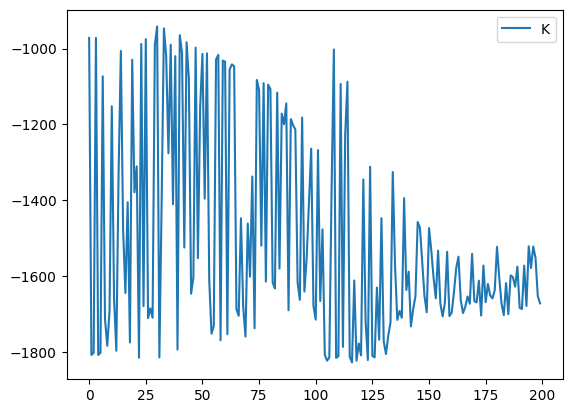

In [ ]:
plt.plot(range(len(kdc_data)), kdc_data[:,0], label = 'K')
#plt.plot(range(len(kdc_data)), kdc_data[:,1], label = 'D')
plt.legend()
plt.plot()

[]

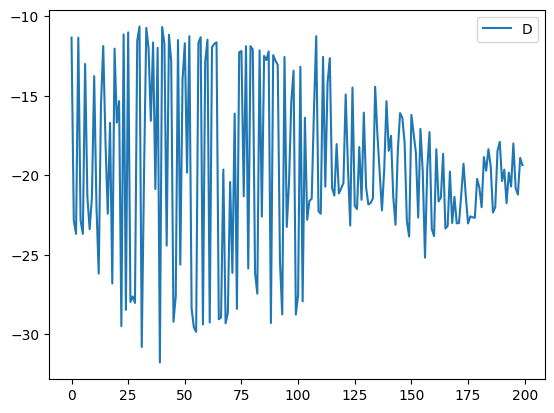

In [ ]:
plt.plot(range(len(kdc_data)), kdc_data[:,1], label = 'D')

plt.legend()
plt.plot()

[]

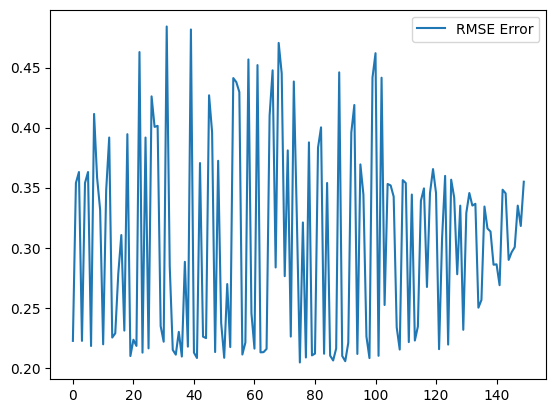

In [ ]:
Errors = [0.222418,0.353875,0.362989,0.222418,0.353875,0.362989,0.218165,0.411349,0.358214,0.331589,0.219554,0.347838,0.391733,0.225197,0.228722,0.278395,0.310534,0.230985,0.394494,0.209805,0.223387,0.218233,0.462875,0.212641,0.391721,0.216191,0.425989,0.400571,0.401438,0.234687,0.221746,0.484176,0.284629,0.214943,0.210963,0.229927,0.209367,0.288249,0.217613,0.481680,0.212658,0.208170,0.370468,0.225957,0.224739,0.426880,0.396124,0.213131,0.372350,0.237293,0.208337,0.269733,0.217272,0.441220,0.437886,0.429605,0.211077,0.221023,0.456743,0.245412,0.215976,0.452033,0.212866,0.213050,0.215728,0.409964,0.447661,0.283542,0.470492,0.445133,0.276276,0.381020,0.225992,0.438379,0.325257,0.204441,0.321015,0.208603,0.387679,0.210345,0.211854,0.383293,0.400201,0.211715,0.353890,0.210165,0.206112,0.216082,0.445981,0.209873,0.205512,0.220856,0.395884,0.418815,0.211547,0.369357,0.344189,0.226062,0.208093,0.441632,0.461936,0.209990,0.441531,0.252288,0.353054,0.351847,0.342550,0.233752,0.215204,0.356249,0.353828,0.221415,0.344259,0.222729,0.234372,0.339107,0.349371,0.267295,0.345472,0.365451,0.345439,0.215514,0.308100,0.359802,0.219333,0.356602,0.341750,0.277891,0.335008,0.231641,0.328848,0.345532,0.335064,0.336552,0.250068,0.256467,0.334277,0.315985,0.313467,0.285834,0.286167,0.268774,0.348257,0.345237,0.289844,0.296334,0.300441,0.335030,0.318088,0.354945]
plt.plot(range(len(Errors)), Errors, label = 'RMSE Error')

plt.legend()
plt.plot()

In [ ]:
path1 = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/x_y_data/x_y_value_for_all_points.csv'
df = pd.read_csv(path1, names = ['x','y'])
print(df.shape)
df.head()

(200, 2)


,x,y
0,-0.0005,-0.0260
1,-0.0005,0.0170
2,-0.0008,0.0183
3,-0.0009,-0.0115
4,-0.0009,0.0066


In [ ]:
from scipy import *
from scipy.linalg import norm, pinv
import math


class RBF:

        def __init__(self, indim, numCenters, outdim):
            self.indim = indim
            self.outdim = outdim
            self.numCenters = numCenters
            self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
            self.beta = 8
            self.W = np.random.random((self.numCenters, self.outdim))

        def _basisfunc(self, c, d):
            assert len(d) == self.indim
            return norm(c-d)**3

        def _calcAct(self, X):
            # calculate activations of RBFs
            G = np.zeros((X.shape[0], self.numCenters), float)
            for ci, c in enumerate(self.centers):
                for xi, x in enumerate(X):
                    G[xi,ci] = self._basisfunc(c, x)
            return G

        def train(self, X, Y):
            """ X: matrix of dimensions n x indim 
                y: column vector of dimension n x 1 """

            # choose random center vectors from training set
            rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
            self.centers = [X[i,:] for i in rnd_idx]

            #print("center", self.centers)
            # calculate activations of RBFs
            G = self._calcAct(X)
            #print(G)

            # calculate output weights (pseudoinverse)
            self.W = np.dot(pinv(G), Y)

        def test(self, X):
            """ X: matrix of dimensions n x indim """

            G = self._calcAct(X)
            Y = np.dot(G, self.W)
            return Y

In [ ]:
y_train = kdc_data
x_train = np.array(df)
x_train.shape, y_train.shape

((200, 2), (200, 3))

In [ ]:
rbf = RBF(2,50, 3)
rbf.train(x_train, y_train)

In [ ]:
y_pred_kdc = rbf.test(x_train)
print('Actual:')
print(y_train[-3:], '\n\nPredictions:\n', y_pred_kdc[-3:])

Actual:
[[-1.55208221e+03 -2.12070340e+01 -1.85443971e-01]
 [-1.65264380e+03 -1.88995059e+01 -7.55362782e-02]
 [-1.67180549e+03 -1.93541197e+01 -6.83972408e-02]] 

Predictions:
 [[-1.60005405e+03 -1.97805664e+01 -1.19894116e-01]
 [-1.60429574e+03 -1.93161290e+01 -1.12142836e-01]
 [-1.60476859e+03 -1.86369262e+01 -9.61842376e-02]]


In [ ]:
y_pred_kdc.shape

(200, 3)

In [ ]:
mini = 50
for train_pt in [76,78,79,80,82]:
    error = []
    pos_train = pd.read_csv(path+f'{train_pt}_foaw_pos_ecoflex_181221_data.csv')
    vel_train = pd.read_csv(path+f'{train_pt}_foaw_velocity_ecoflex_181221_data.csv')
    f1_train = pd.read_csv(path+f'{train_pt}_foaw_force_ecoflex_181221_data.csv')

    #print(pos_train.shape, vel_train.shape, f1_train.shape)
    x_train = np.concatenate([np.array(pos_train),np.array(vel_train)],axis=1)
    y_train = np.array(f1_train)

    lr1 = LinearRegression()
    lr1.fit(x_train,y_train)

    for point in range(60,101):
        pos_test = pd.read_csv(path+f'{point}_foaw_pos_ecoflex_181221_data.csv')
        vel_test = pd.read_csv(path+f'{point}_foaw_velocity_ecoflex_181221_data.csv')
        f1_test = pd.read_csv(path+f'{point}_foaw_force_ecoflex_181221_data.csv')

        #print(pos_test.shape, vel_test.shape, f1_test.shape) other point testing
        x_test = np.concatenate([np.array(pos_test),np.array(vel_test)],axis=1)
        y_test = np.array(f1_test)

        m = min(len(y_train), len(y_test))

        y1 = y_pred_kdc[point-1][0]*x_test[:,0]+y_pred_kdc[point-1][1]*x_test[:,1]
        #print(y1.shape[0], x_test.shape[0])
        y1 = y1.reshape((-1,1))
        delta_f = y1[:m]-y_train[:m]

        # prediction using lr1 corresponds to K1, D1 prediction

        y_pred = lr1.predict(x_test[:m])+delta_f
        error.append(mean_squared_error(y_test[:m],y_pred)**0.5)

    error = np.array(error)
    mini = min(mini, np.mean(error))
    statement = f'For point = {train_pt}, mean rmse ={np.mean(error)}, Standard deviation = {np.std(error)}\n'
    with open('results.txt','a') as f:
        f.write(statement)

27236 27236
27238 27238
27237 27237
27235 27235
27239 27239
27238 27238
27234 27234
27240 27240
27237 27237
27242 27242
27235 27235
27236 27236
27235 27235
27235 27235
27236 27236
27225 27225
27237 27237
27237 27237
27237 27237
27234 27234
27236 27236
27238 27238
27235 27235
27238 27238
27235 27235
27238 27238
27235 27235
27238 27238
27235 27235
27238 27238
27236 27236
27234 27234
27241 27241
27234 27234
27236 27236
27237 27237
27235 27235
27240 27240
27235 27235
27236 27236
27234 27234
27236 27236
27238 27238
27237 27237
27235 27235
27239 27239
27238 27238
27234 27234
27240 27240
27237 27237
27242 27242
27235 27235
27236 27236
27235 27235
27235 27235
27236 27236
27225 27225
27237 27237
27237 27237
27237 27237
27234 27234
27236 27236
27238 27238
27235 27235
27238 27238
27235 27235
27238 27238
27235 27235
27238 27238
27235 27235
27238 27238
27236 27236
27234 27234
27241 27241
27234 27234
27236 27236
27237 27237
27235 27235
27240 27240
27235 27235
27236 27236
27234 27234
27236 27236
2723